In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPool2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import glob
import cv2
import matplotlib.pyplot as plt
from google.colab import drive
import random

In [2]:
drive.mount('/content/drive')
%cd '/content/drive/My Drive/adv_assignment'   

#%cd '/content/drive/My Drive/Advanced_Assignment_Dataset'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/adv_assignment


# Initial Data Processing

We first load in all the image names

In [24]:
#list of all image file names , example="NoSunglasses0.pgm"
filenames=glob.glob("*.pgm")   

#No. of images
m_given=len(filenames)         
print(f"No. of images in the dataset = {m_given}")

random.shuffle(filenames)

#All images will be converted to the shape (128,128)
h=128

directions=['left','right','straight','up']
emotions=['angry','happy','neutral','sad']
sunglasses=['open','sunglasses']

No. of images in the dataset = 632


However, this time we would prefer not to simply distribute the data randomly. This time we have all together 32 combination of classes and random distribution may cause some uneven distribution. 

Therefore, we will first segregate the given data into 32 different classes and then distribute randomly so that each class is roughly equally represented in train, valid and test data sets.

In [27]:
#Initializing the dictionary filenames_segregated
filenames_segregated={}
for i in range(4):
  for j in range(4):
    for k in range(2):
      filenames_segregated[f'{i}{j}{k}']=[]

#Initializing the array to store number of images per each class
num_images=np.zeros([4,4,2])

#Segregating the filenames into 32 different classes based on 3 attributes
for filename in filenames:
  direction,emotion,glass,_=filename.split('_')
  i=directions.index(direction)
  j=emotions.index(emotion)
  k=sunglasses.index(glass)
  num_images[i][j][k]+=1
  filenames_segregated[f'{i}{j}{k}']+=[filename]

m_train=0
m_valid=0
m_test=0

#Distribution between train,valid and test dataset based on no. of images in each of 32 classes. 
#So for example, if no. of images in a particular class is 20 then 12 of them willgo to train set,
#  2 of them will go to valid set and 6 of them would go to test set. 
distribution={18:[11,2,5],
              19:[11,2,6],
              20:[12,2,6],
              22:[13,3,6],
              25:[15,3,7]}

#Compute the no. of images that will be present in train,valid and test set before augmentation.              
for i in range(4):
  for j in range(4):
    for k in range(2):
      m_train+=distribution[num_images[i][j][k]][0]
      m_valid+=distribution[num_images[i][j][k]][1]
      m_test+=distribution[num_images[i][j][k]][2]


print(num_images,m_train,m_valid,m_test)

[[[19. 19.]
  [20. 20.]
  [20. 19.]
  [20. 20.]]

 [[20. 19.]
  [19. 22.]
  [25. 20.]
  [18. 20.]]

 [[18. 20.]
  [20. 19.]
  [20. 20.]
  [20. 19.]]

 [[20. 20.]
  [19. 19.]
  [20. 19.]
  [20. 19.]]] 375 66 191


After this the distribution is 

train = 375 images

valid = 66 images

test =191 images

In [31]:
#Initializing the arrays to store train,valid and test sets
given_X_train=np.zeros([m_train,h,h,1])
given_y_train=np.zeros([m_train,3])
given_X_valid=np.zeros([m_valid,h,h,1])
given_y_valid=np.zeros([m_valid,3])
X_test=np.zeros([m_test,h,h,1])
y_test=np.zeros([m_test,3])

#helper function to read in the image and apply necessary transforms on it
def read_in(image_name):
  img=cv2.imread(image_name,0)
  if img is None:
    print("Invalid image")
  img=cv2.resize(img,(h,h))
  img=img.reshape((h,h,1))
  return img 

#Converting the images into numpy array and storing them separately in train,valid and test sets.
ind1=ind2=ind3=0
for i in range(4):
  for j in range(4):
    for k in range(2):
      f=filenames_segregated[f'{i}{j}{k}']
      num=len(f)
      for t in range(num):
        if t<distribution[num][0]:
          given_X_train[ind1]=read_in(f[t])
          given_y_train[ind1]=[i,j,k]
          ind1+=1
        elif t<distribution[num][0]+distribution[num][1]:
          given_X_valid[ind2]=read_in(f[t])
          given_y_valid[ind2]=[i,j,k]
          ind2+=1
        else :
          X_test[ind3]=read_in(f[t])
          y_test[ind3]=[i,j,k]
          ind3+=1

(191, 128, 128, 1)


We will now enlarge our training and validation datasets by a factor of 40 using data augmentation. 

In [59]:
train_data_gen=ImageDataGenerator(
    height_shift_range=0.15,
    width_shift_range=0.2,
    rotation_range=20,                                                
    shear_range=0.2,
    zoom_range=[0.7,1.15]                       
)

valid_data_gen=ImageDataGenerator(
    height_shift_range=0.15,
    width_shift_range=0.15
)

In [60]:
factor=40  #The factor by which the dataset is to be multiplied
m_train=len(given_y_train)
m_valid=len(given_y_valid)

#generate all training images after augmnetation 
X_train=np.zeros([factor*m_train,h,h,1])                                
y_train=np.zeros([factor*m_train,3])
for i in range(factor):                                                    
  it=train_data_gen.flow(given_X_train,given_y_train,batch_size=m_train)                        
  temp=next(it)
  X_train[i*m_train:(i+1)*m_train,:,:,:]=temp[0]                                 
  y_train[i*m_train:(i+1)*m_train,:]=temp[1]      

#Generate all validation images after augmnetation
X_valid=np.zeros([factor*m_valid,h,h,1])                                
y_valid=np.zeros([factor*m_valid,3])
for i in range(factor):                                                    
  it=valid_data_gen.flow(given_X_valid,given_y_valid,batch_size=m_valid)                        
  temp=next(it)
  X_valid[i*m_valid:(i+1)*m_valid,:,:,:]=temp[0]                                 
  y_valid[i*m_valid:(i+1)*m_valid,:]=temp[1] 

After data augmentation the distribution is 

**train = 15000 images generated from 375 images**

**valid = 2640 images generated from 66 images**

**test = 191 images generated from 191 images**

In [61]:
#Shuffling the resulting data sets 
pos=np.arange(len(y_train))
np.random.shuffle(pos)          
X_train=X_train[pos]
y_train=y_train[pos]

pos=np.arange(len(y_valid))
np.random.shuffle(pos)          
X_valid=X_valid[pos]
y_valid=y_valid[pos]

pos=np.arange(len(y_test))
np.random.shuffle(pos)          
X_test=X_test[pos]
y_test=y_test[pos]

Alas! We are done with the tedious process of data processing and we can now save them :)

In [62]:
np.save('X_train',X_train)
np.save('y_train',y_train)
np.save('X_valid',X_valid)
np.save('y_valid',y_valid)
np.save('X_test',X_test)
np.save('y_test',y_test)

# Load Processed Data

In [3]:
X_train=np.load('X_train.npy')
y_train=np.load('y_train.npy')
X_valid=np.load('X_valid.npy')
y_valid=np.load('y_valid.npy')
X_test=np.load('X_test.npy')
y_test=np.load('y_test.npy')

#get the shape of image which is (h,h)
h=X_train.shape[1]
print(h)

128


# Quick peek into some examples

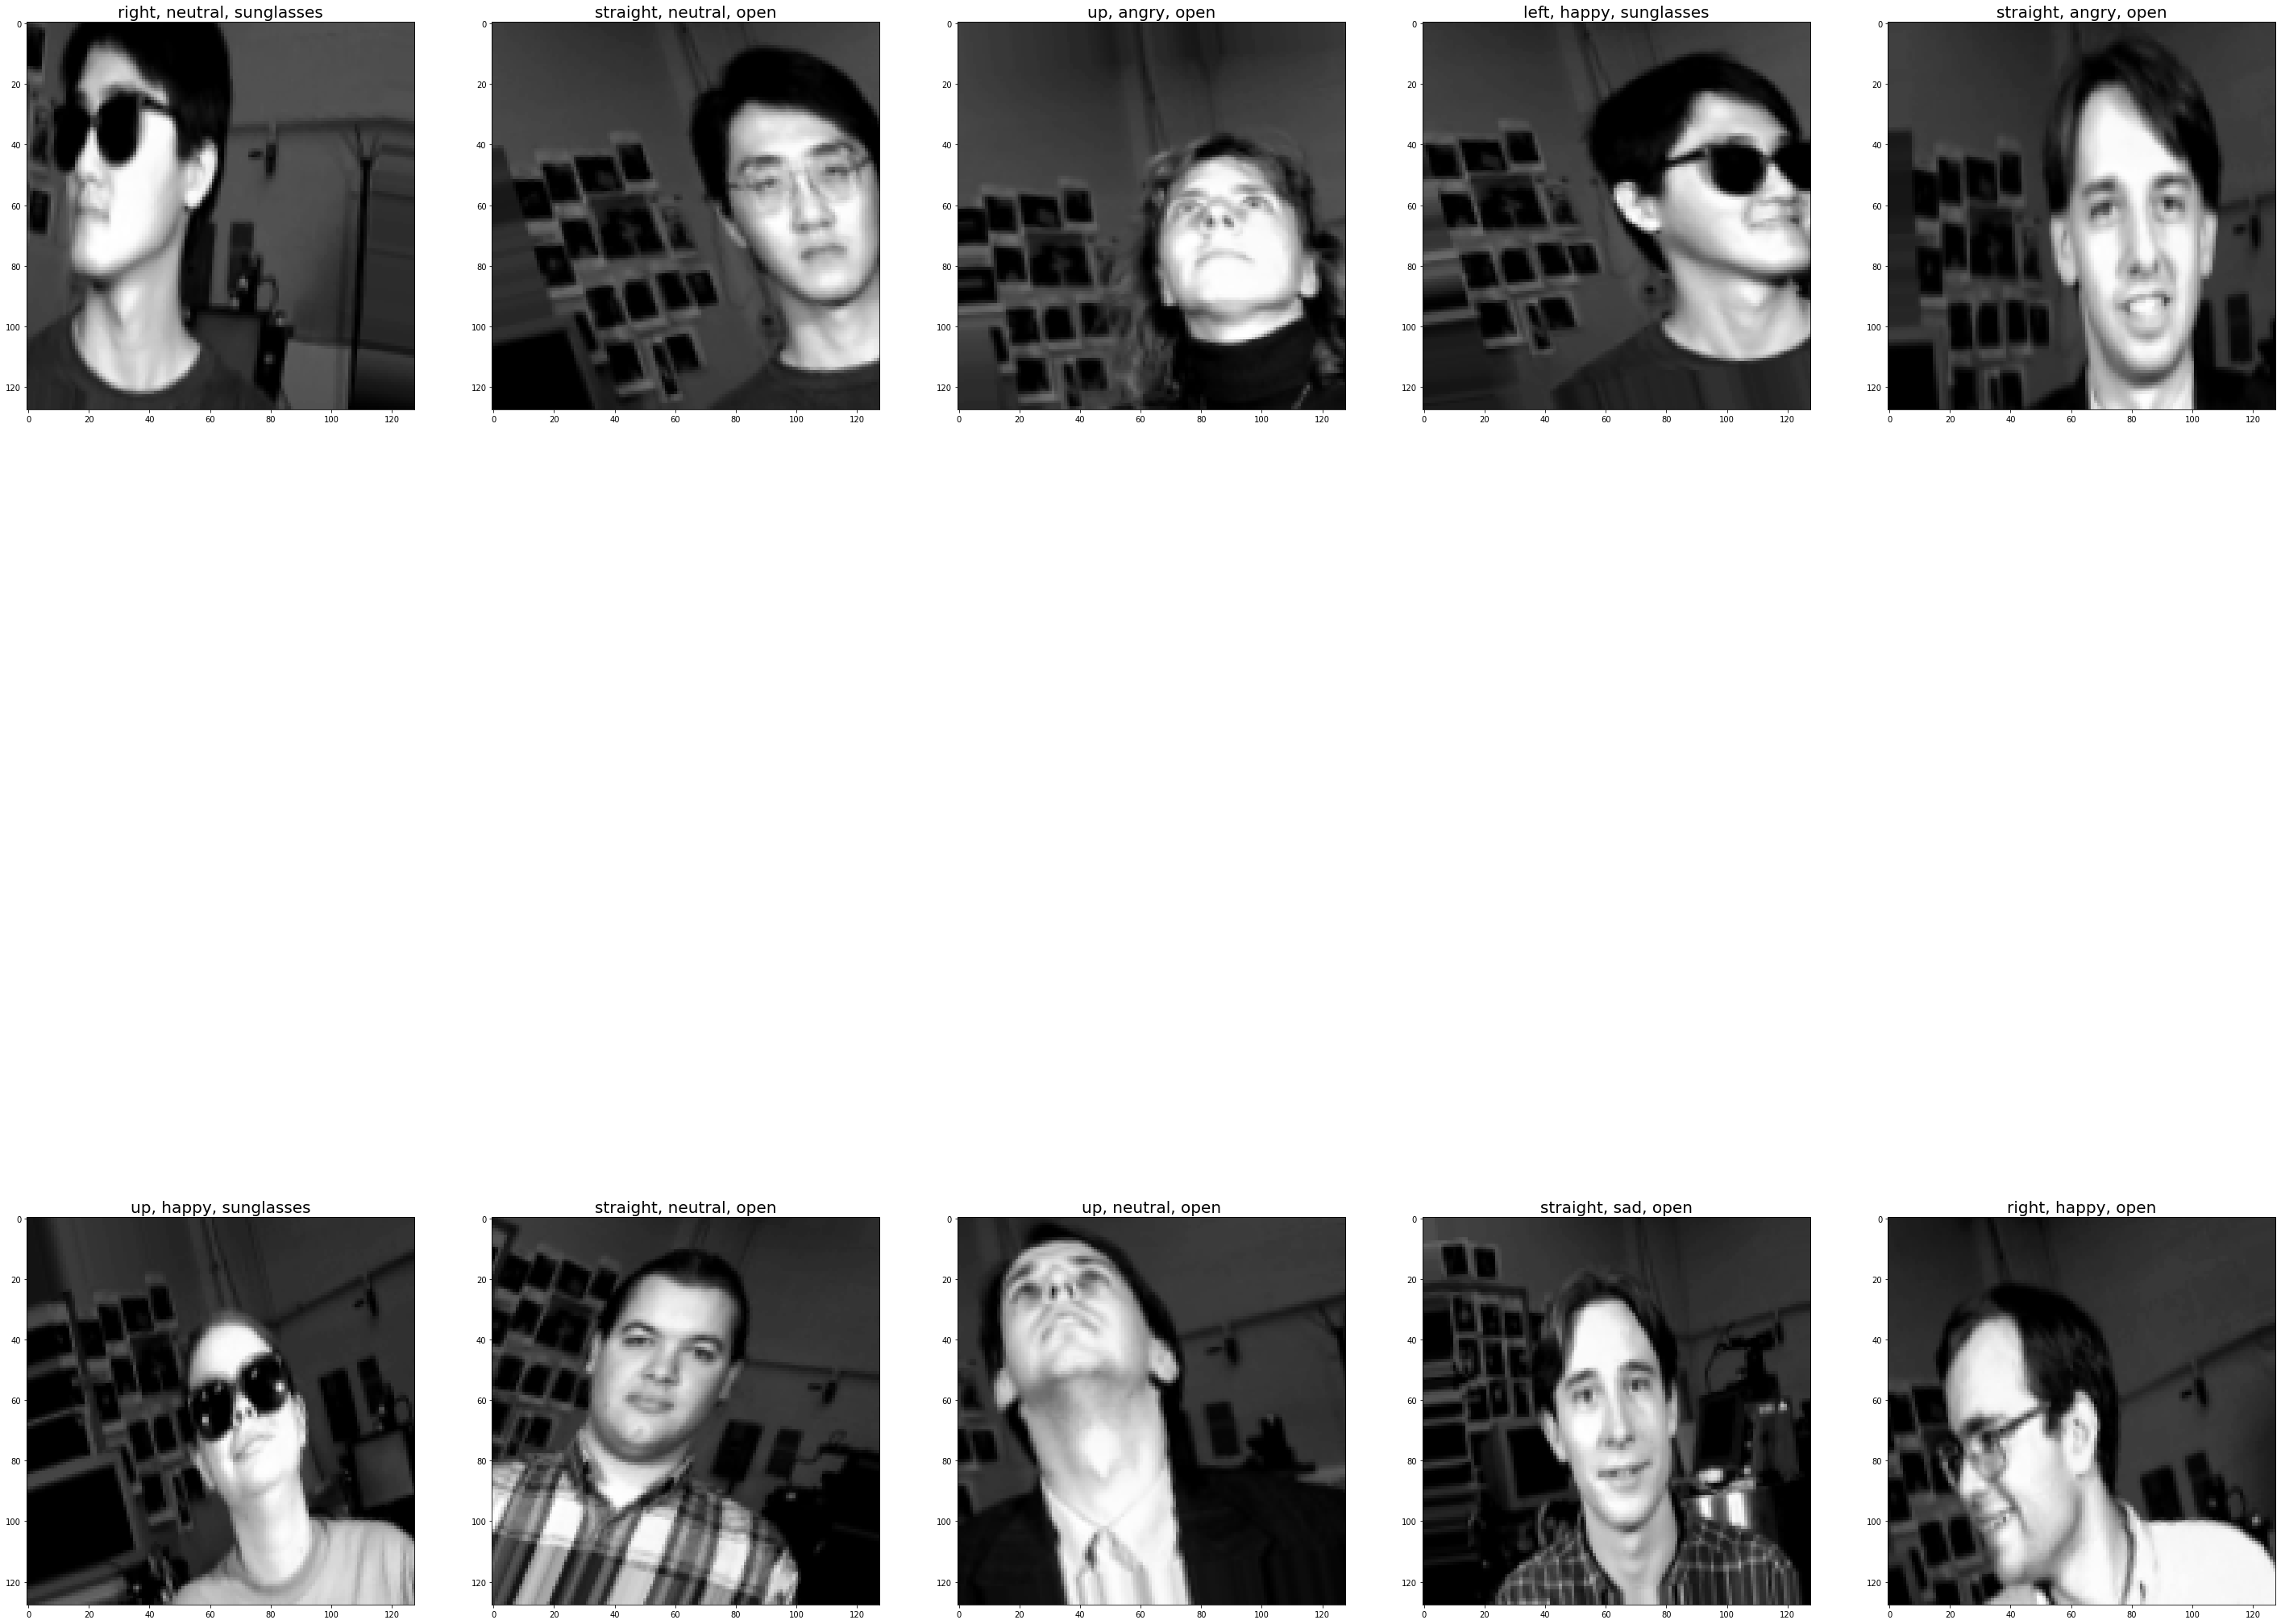

In [65]:
fig=plt.figure(figsize=(50,50))   
for i in range(10):
  sub=fig.add_subplot(2,5,i+1)
  img=X_train[i+1000].copy()
  img=img.reshape((h,h))
  sub.imshow(img.astype(np.uint8),cmap='gray')
  temp=y_train[i+1000]
  plt.title(directions[int(temp[0])]+", "+emotions[int(temp[1])]+", "+sunglasses[int(temp[2])],fontsize=20)        
plt.show()

# Build and train the model

In [4]:
#Normalizing all the images 
X_train=X_train/255.0
X_valid=X_valid/255.0
X_test=X_test/255.0

Model: "adv_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
sequential_4 (Sequential)       (None, 8, 8, 256)    398592      input_5[0][0]                    
                                                                 input_5[0][0]                    
                                                                 input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_64 (Conv2D)              (None, 8, 8, 32)     73760       sequential_4[0][0]               
__________________________________________________________________________________________

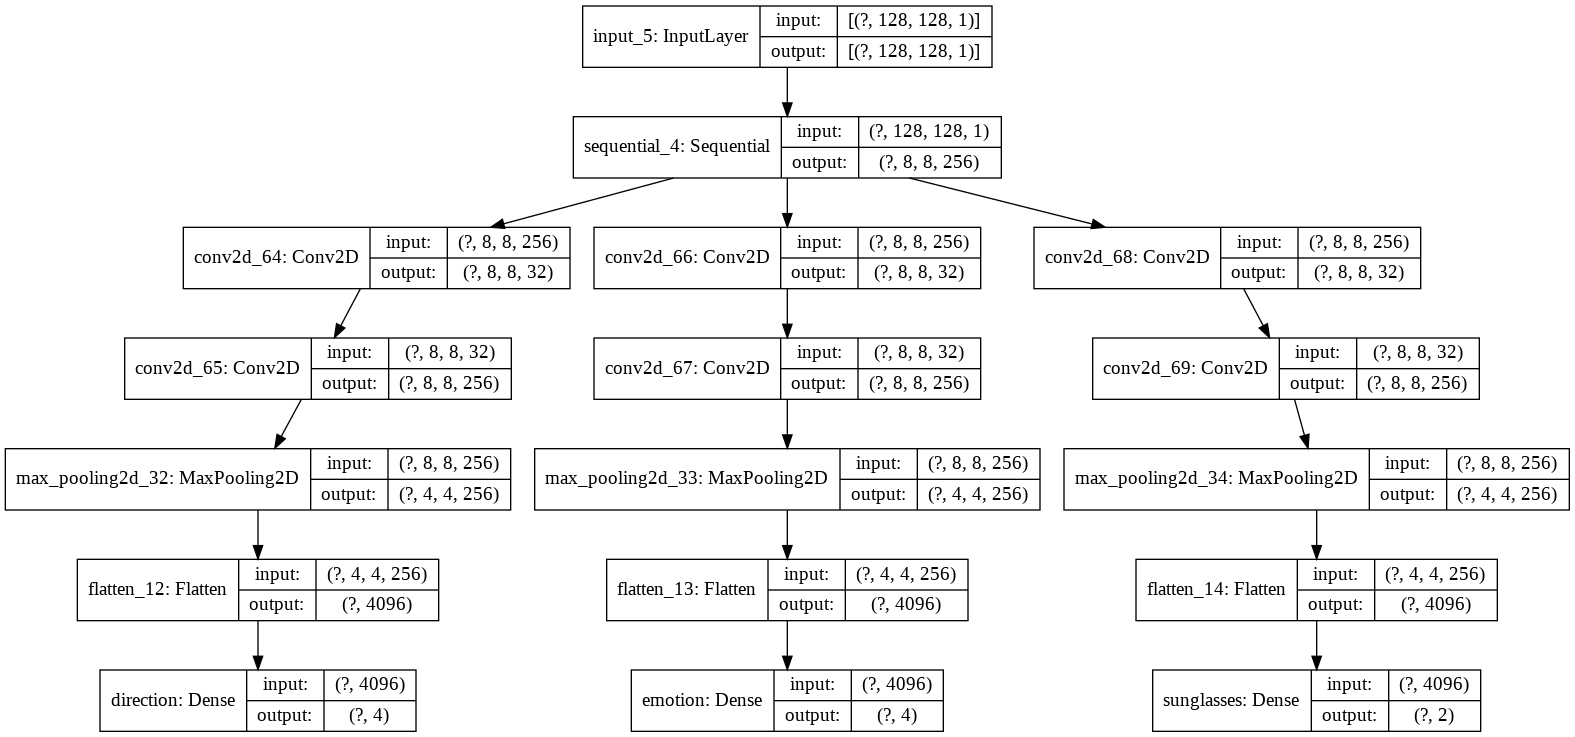

In [16]:
inputs=tf.keras.Input(shape=(h,h,1))

#The base part of the model which will act as a feature extracter common to all the 3 classification.
base_model=tf.keras.Sequential([
       Conv2D(32,3,1,padding='same',activation='relu'),
              #input_shape=(h,h,1)),
       Conv2D(32,3,1,padding='same',activation='relu'),
       MaxPool2D(2,2,padding='valid'),

       Conv2D(64,3,1,padding='same',activation='relu'),
       Conv2D(64,3,1,padding='same',activation='relu'),
       MaxPool2D(2,2,padding='valid'),
       BatchNormalization(),

       Conv2D(128,3,1,padding='same',activation='relu'),
       Conv2D(128,3,1,padding='same',activation='relu'),
       MaxPool2D(2,2,padding='valid'),

       Conv2D(32,3,1,padding='same',activation='relu'),
       Conv2D(256,3,1,padding='same',activation='relu'),
       MaxPool2D(2,2,padding='valid'),
       BatchNormalization(),

       #Flatten(),
       #Dense(3,activation='sigmoid')
])

x=base_model(inputs)
y=base_model(inputs)
z=base_model(inputs)

#Sub-network for direction
x=Conv2D(32,3,1,padding='same',activation='relu')(x)
x=Conv2D(256,3,1,padding='same',activation='relu')(x)
x=MaxPool2D(2,2,padding='valid')(x)
x=Flatten()(x)
output_1=Dense(4,activation='softmax',name='direction')(x)

#Sub-network for emotion 
y=Conv2D(32,3,1,padding='same',activation='relu')(y)
y=Conv2D(256,3,1,padding='same',activation='relu')(y)
y=MaxPool2D(2,2,padding='valid')(y)
y=Flatten()(y)
output_2=Dense(4,activation='softmax',name='emotion')(y)

#Sub-network for sunglasses
z=Conv2D(32,3,1,padding='same',activation='relu')(z)
z=Conv2D(256,3,1,padding='same',activation='relu')(z)
z=MaxPool2D(2,2,padding='valid')(z)
z=Flatten()(z)
output_3=Dense(2,activation='softmax',name='sunglasses')(z)

outputs=[output_1,output_2,output_3]
model=tf.keras.Model(inputs=inputs,outputs=outputs,name='adv_model')

model.compile(optimizer='adagrad',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

#Show the summary
model.summary()

#Show the graph with the shapes
tf.keras.utils.plot_model(model,show_shapes=True)

In [18]:
epochs=10
history=model.fit(X_train,
                  [y_train[:,0],y_train[:,1],y_train[:,2]],
                  batch_size=64,
                  epochs=epochs,
                  validation_data=(X_valid,[y_valid[:,0],y_valid[:,1],y_valid[:,2]]))

Epoch 1/10
235/235 [==============================] - 66s 279ms/step - loss: 0.9236 - direction_loss: 0.0042 - emotion_loss: 0.9163 - sunglasses_loss: 0.0031 - direction_accuracy: 0.9999 - emotion_accuracy: 0.6597 - sunglasses_accuracy: 0.9993 - val_loss: 2.1554 - val_direction_loss: 0.0675 - val_emotion_loss: 2.0871 - val_sunglasses_loss: 8.8352e-04 - val_direction_accuracy: 0.9769 - val_emotion_accuracy: 0.1383 - val_sunglasses_accuracy: 1.0000
Epoch 2/10
235/235 [==============================] - 65s 278ms/step - loss: 0.8806 - direction_loss: 0.0041 - emotion_loss: 0.8739 - sunglasses_loss: 0.0026 - direction_accuracy: 0.9998 - emotion_accuracy: 0.6823 - sunglasses_accuracy: 0.9996 - val_loss: 2.2491 - val_direction_loss: 0.0919 - val_emotion_loss: 2.1504 - val_sunglasses_loss: 0.0068 - val_direction_accuracy: 0.9742 - val_emotion_accuracy: 0.0981 - val_sunglasses_accuracy: 0.9981
Epoch 3/10
235/235 [==============================] - 65s 277ms/step - loss: 0.8400 - direction_loss: 

Text(0.5, 1.0, 'Training and Validation Accuracy')

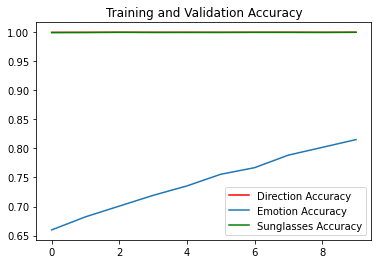

In [25]:
#acc=history.history['accuracy']
direction_acc=history.history['direction_accuracy']
emotion_acc=history.history['emotion_accuracy']
sunglasses_acc=history.history['sunglasses_accuracy']

epochs_range=range(epochs)
plt.plot(epochs_range, direction_acc, label='Direction Accuracy',color='red')
plt.plot(epochs_range, emotion_acc, label='Emotion Accuracy')
plt.plot(epochs_range, sunglasses_acc, label='Sunglasses Accuracy',color='green')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


# Test the model

In [9]:
model.evaluate(X_test,[y_test[:,0],y_test[:,1],y_test[:,2]])

6/6 [==============================] - 1s 104ms/step - loss: 3.0225 - dense_3_loss: 0.0028 - dense_4_loss: 3.0119 - dense_5_loss: 0.0077 - dense_3_accuracy: 1.0000 - dense_4_accuracy: 0.1518 - dense_5_accuracy: 0.9948


[3.022480010986328,
 0.002828159835189581,
 3.011916160583496,
 0.007735824212431908,
 1.0,
 0.1518324613571167,
 0.9947643876075745]